In [1]:
#%run utility_GetInputHits.py

In [2]:
from root_pandas import read_root
from HGCalImageAlgo3D import *
import tqdm

%matplotlib inline
plt.style.use('classic')
plt.rc("figure",facecolor="w",figsize=(6,4))
plt.rc("font",size=10)
plt.rc("savefig",dpi=300)

Welcome to JupyROOT 6.10/00


In [3]:
DatasetFile   = 'CMSSW9304_partGun_PDGid22_x100_E30.0To30.0_NTUP'
df  = pd.read_pickle("../data/input/"+DatasetFile+"_rechit.pkl") 

# 1. Run clustering

In [14]:
dfresultclus     = pd.DataFrame()
for ievt in tqdm.tqdm(np.unique(df.id)):
    if ievt<100:
        #_,dfevtclus   = ImageAlgorithm_cpu (df[df.id==ievt],ievt)
        #_,dfevtclus   = ImageAlgorithm_cuda(df[df.id==ievt],ievt)
        _,dfevtclus   = ImageAlgorithm_opencl(df[df.id==ievt],ievt,2)
        dfresultclus  = dfresultclus.append(dfevtclus, ignore_index=True)

dfresultclus.to_pickle("../data/output/"+DatasetFile+"_OutputClus.pkl")

100%|██████████| 100/100 [00:03<00:00, 25.31it/s]


# 2.Make Some Plots

In [6]:
dfc = read_root("/Users/zihengchen/Documents/HGCal/clustering/data/"+DatasetFile+".root",'ana/hgc')
energy3d,count3d = [],[]
for i in np.arange(len(dfc)):
    slt = dfc.multiclus_z[i]>0
    energyi = dfc.multiclus_energy[i][slt]
    energy3d.append(np.sum(energyi))
    count3d.append(energyi.size)
energy3d = np.array(energy3d)
count3d = np.array(count3d)

In [7]:
def effsigma(arr):
    ntotal = len(arr)
    npeak  = int(0.683*ntotal)
    ewidth = int(1e5)

    e = sort(arr)[::-1]
    for i in range(ntotal-npeak-1):
        temp = e[i]-e[i+npeak]
        if temp<ewidth:
            ewidth = temp 
    return ewidth/2,e.mean()

ImageAlgo3D:0.05772471730597317,28.517426971541717
cmssw:0.05285209019978841,26.518871307373047


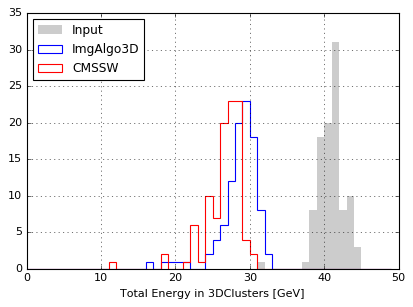

In [8]:
f = plt.hist(dfresultclus["clust_inputenergy"],color="k",bins=np.arange(0,50,1),alpha=0.2,histtype="stepfilled",lw=0,label="Input")
f = plt.hist(dfresultclus["clust_includedenergy"],color="b",bins=np.arange(0,50,1),alpha=1,histtype="step",lw=1,label="ImgAlgo3D")
f = plt.hist(energy3d,color="r",bins=np.arange(0,50,1),alpha=1,histtype="step",lw=1,label="CMSSW")

plt.grid(True)
plt.legend(loc="upper left",fontsize=11)
plt.xlabel("Total Energy in 3DClusters [GeV]")


eff,ave = effsigma(dfresultclus["clust_includedenergy"])
eff = eff/30

print("ImageAlgo3D:{},{}".format(eff,ave))

eff,ave = effsigma(energy3d)
eff = eff/30
print("cmssw:{},{}".format(eff,ave))

plt.savefig("../plot/result_energy.png")

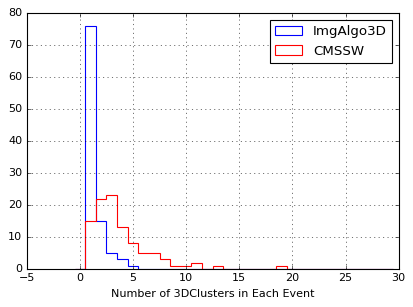

In [9]:
f = plt.hist(dfresultclus["clust_n"],bins=np.arange(-.5,30,1),color="b",alpha=1,
             histtype="step", lw=1,label="ImgAlgo3D")
f = plt.hist(count3d,bins=np.arange(-.5,30,1),color="r",alpha=1,
             histtype="step", lw=1,label="CMSSW")
plt.grid(True)
plt.legend()
plt.xlabel("Number of 3DClusters in Each Event")
plt.savefig("../plot/result_nclus.png")